In [1]:
import earthkit.data
import earthkit.plots
import earthkit.aggregate

import xarray as xr

/Users/mavj/opt/miniconda3/envs/DEVELOP/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
MODELS = [
    'hadgem3_gc31_ll',
    'inm_cm5_0',
    'inm_cm4_8',
    'ipsl_cm6a_lr', 
    'miroc_es2l',
    'mpi_esm1_2_lr',
]

EXPERIMENTS = [
    'historical',
    'ssp126',
    'ssp245',
    'ssp585',
]

HISTORICAL_YEARS = [str(year) for year in range(1850, 2015)]
PROJECTIONS_YEARS = [str(year) for year in range(2015, 2100)]

In [3]:
data = {}

for experiment in EXPERIMENTS:
    data[experiment] = []
    years = HISTORICAL_YEARS if experiment == "historical" else PROJECTIONS_YEARS
    for model in MODELS:
        data[experiment].append(
            earthkit.data.from_source(
                "cds",
                    'projections-cmip6',
                {
                    'format': 'zip',
                    'temporal_resolution': 'monthly',
                    'experiment': experiment,
                    'variable': 'near_surface_air_temperature',
                    'model': model,
                    'year': years,
                    'month': [f"{month:02d}" for month in range(1, 13)],
                },
            ).to_xarray().tas
        )

In [4]:
timeseries = {}

for experiment in EXPERIMENTS:
    data[experiment] = [earthkit.aggregate.temporal.standardise_time(d) for d in data[experiment]]
    data[experiment] = xr.concat(data[experiment], dim="model")
    yearly = earthkit.aggregate.temporal.resample(data[experiment], frequency="YE")
    timeseries[experiment] = earthkit.aggregate.spatial.reduce(yearly)

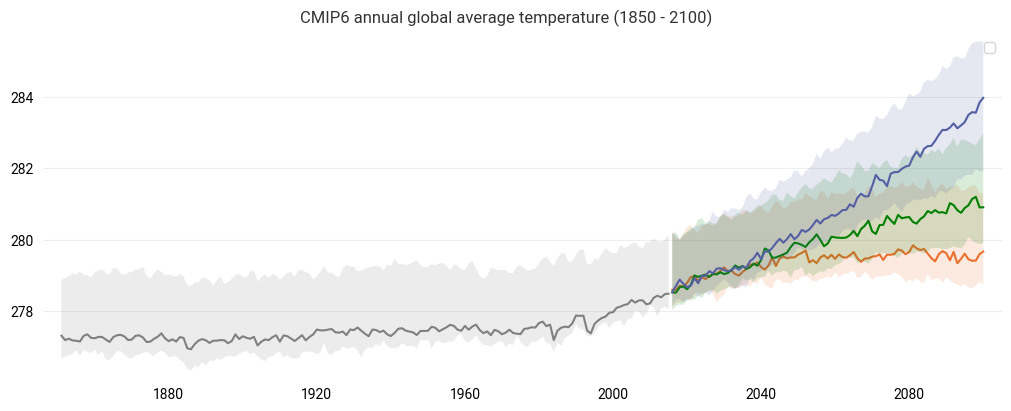

In [5]:
figure = earthkit.plots.Figure(size=(10, 4))
subplot = figure.add_subplot()
for experiment, color in zip(timeseries, ["grey", "#EB702D", "green", "#545FA4"]):
    subplot.quantiles(timeseries[experiment], quantiles=[0.1, 0.5, 0.9], alpha=0.15, color=color, x=timeseries[experiment].isel(model=0).time)
figure.title("CMIP6 annual global average temperature (1850 - 2100)")

subplot.ax.legend()

figure.show()